done


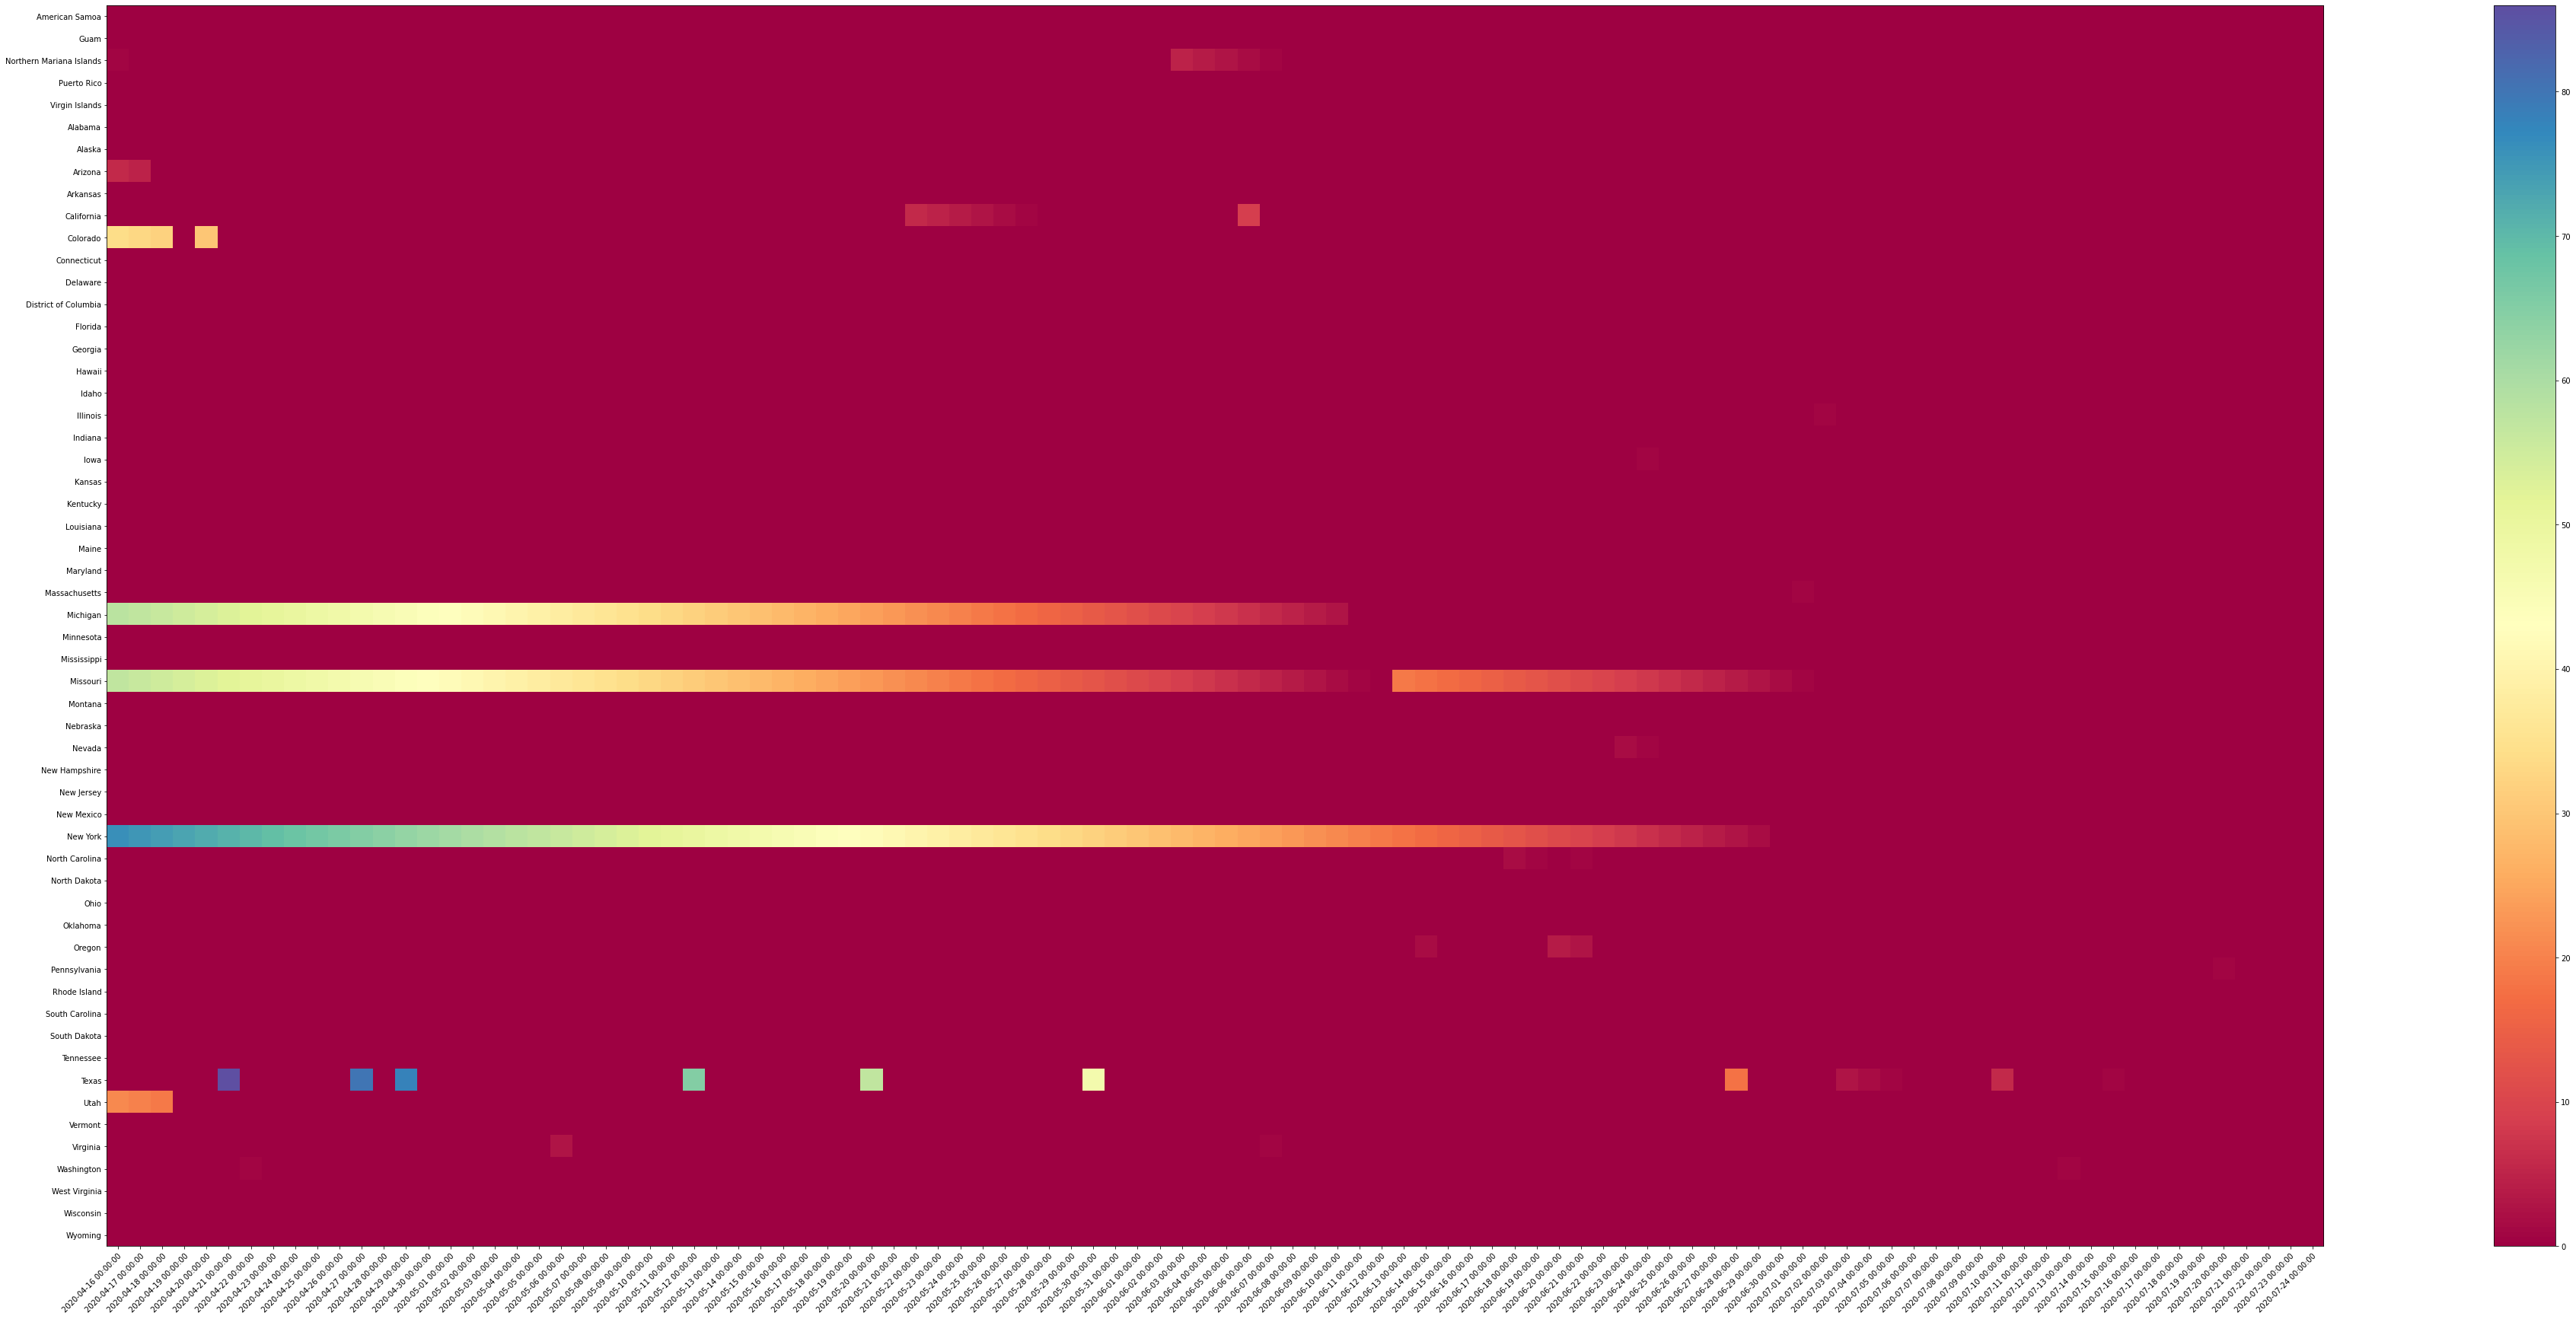

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

data_generated="26072020"
directory = "historic_"+data_generated

us_states = []
dates = []
df = []
dpd = []

# get all dates
filename = directory+"/"+"us_deaths_100.csv"
data = pd.read_csv( filename, parse_dates=True, dayfirst=False) 
data = data[data.Population>0]
dates = data['Data'].unique()

for days_ago in range(100,0,-1):
    filename = directory+"/"+"us_deaths_"+str(days_ago)+".csv"
    # data has one row per day for all counties
    data = pd.read_csv( filename, parse_dates=True, dayfirst=False) 
    # remove lines with 0 population
    data = data[data.Population>0]
    s_data = data[['Province/State','Date','Case']].groupby(['Province/State','Date']).sum()
    # which date is this file from
#    csv_date = pd.to_datetime(data['Date'].max(), format='%Y-%m-%d')
    csv_date = data['Date'].max()
    # first run? initalize
    if len(us_states)==0:
        us_states = data['Province/State'].unique()
        df = pd.DataFrame( 0, 
                           index=pd.MultiIndex.from_product([us_states,dates], 
                                                            names=['state', 'dates']),
                           columns=["delay","count"])

    s_dates = []
    # loop through the data
    for state in us_states:
        # loop though result dates
        state_data = s_data.loc[state]
        if len(s_dates)==0:
            s_dates = pd.to_datetime(state_data.index)
        # the index 
        r_date_index = 0
        for r_date in dates:
            # if csv has data for this date:
            if r_date in s_dates:
                data_date_str = r_date.strftime("%Y-%m-%d")
                # if last value we know is 0, just set it
                new_val = state_data.loc[data_date_str]['Case']
                if df.loc[(state,r_date),'count']==0:
                    df.loc[(state,r_date),'count'] = new_val
                    df.loc[(state,r_date),'delay'] = 0
                # if last value is different, set it and calc the number of days
                #   between when the csv file is from and the date we are looking at
                elif df.loc[(state,r_date),'count'] != new_val:
                    # the csv is ... days after the original date
                    delay_count = (csv_date - r_date).days
                    df.loc[(state,r_date),'count'] = new_val
                    df.loc[(state,r_date),'delay'] = delay_count            
            r_date_index += 1
        #print(state)
        #print(df.loc[state,'delay'].tolist())

# finally, when the data for this state has been calculated,
# put the result back

for state in us_states:
    dpd.append(df.loc[state,'delay'].tolist())
        
dpd = np.array(dpd)

fig, ax = plt.subplots()
im = ax.imshow(dpd, cmap="Spectral")

# We want to show all ticks...
ax.set_xticks(np.arange(len(dates)))
ax.set_yticks(np.arange(len(us_states)))
# ... and label them with the respective list entries
ax.set_xticklabels(dates)
ax.set_yticklabels(us_states)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig.colorbar(im)

# Loop over data dimensions and create text annotations.
#for i in range(len(us_states)):
#    for j in range(len(dates)):
#        text = ax.text(j, i, dpd[i, j],
#                       ha="center", va="center", color="w")


fig = plt.gcf()
fig.set_size_inches(80, 30)
fig.savefig('d.jpeg', dpi=100)
print("done")

In [14]:
# Rewrite Files for better response times and better analysis options

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from tqdm import tqdm

data_generated="26072020"
directory = "historic_"+data_generated

# get all dates
filename = directory+"/"+"us_deaths_1.csv"
data = pd.read_csv( filename, parse_dates=['Date'], dayfirst=False) 
data = data[data.Population>0]
dates = data['Date'].unique().copy()
dates_str = [pd.to_datetime(i).date().strftime("%Y-%m-%d") for i in dates]
us_states = data['Province/State'].unique()
tuples = [(d1,state,d2) for d1 in dates for state in us_states for d2 in dates]
index = pd.MultiIndex.from_tuples(tuples)
df = pd.DataFrame( 0, index=index, columns=["Case"])
df.sort_index(inplace=True)

for days_ago in tqdm(range(100,0,-1)):
    filename = directory+"/"+"us_deaths_"+str(days_ago)+".csv"
    # data has one row per day for all counties
    data = pd.read_csv( filename, parse_dates=True, dayfirst=False) 
    # remove lines with 0 population
    data = data[data.Population>0]
    all_state_data = data[['Province/State','Date','Case']].groupby(['Province/State','Date']).sum()
    idx = pd.IndexSlice
    #print(s_data.loc[idx['Alabama',pd.to_datetime('2020-01-22')],'Case'])
    #print(s_data.loc[idx['Alabama',:],'Case'].tolist()) 
    # which date is this file from
    csv_date = data['Date'].max()
    # loop through the data
    for state in us_states:
        for date, date_str in zip(dates, dates_str):
            try:
                idx_s = pd.IndexSlice
                idx_t = pd.IndexSlice
                cases = all_state_data.loc[idx_s[state,date_str],'Case']
                df.loc[idx_t[csv_date,state,date],'Case'] = cases
            except KeyError as e:
                pass

df.to_pickle("historical_state_cases.pickle")

100%|██████████| 100/100 [11:17<00:00,  6.77s/it]


In [26]:
dt1 = pd.to_datetime('2020-07-10')
dt2 = pd.to_datetime('2020-07-31')
pd.set_option('display.max_rows', 1000)
print(df.loc[idx[dt1:dt2,'New York',dt1:dt2],'Case'].unstack())

                     2020-07-10  2020-07-11  2020-07-12  2020-07-13  \
2020-07-10 New York     32331.0         0.0         0.0         0.0   
2020-07-11 New York     32331.0     32343.0         0.0         0.0   
2020-07-12 New York     32331.0     32343.0     32350.0         0.0   
2020-07-13 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-14 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-15 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-16 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-17 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-18 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-19 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-20 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-21 New York     32331.0     32343.0     32350.0     32395.0   
2020-07-22 New York     32331.0     32343.0     32350.0     32395.0   
2020-0

# Sample Code for Indexing

In [76]:
#print(df.index.levels)
s_data = data[['Province/State','Date','Case']].groupby(['Province/State','Date']).sum()
idx = pd.IndexSlice
print(s_data.loc[idx['Alabama',pd.to_datetime('2020-01-22')],'Case'])
#print(s_data.loc[idx['Alabama',:],'Case'].tolist())
idx2 = pd.IndexSlice
#print(df.index[0])
dt1 = pd.to_datetime('2020-06-22')
dt2 = pd.to_datetime('2020-07-03')
idx = pd.IndexSlice
print(df.loc[idx[dt1:dt2,'New York',dt1:dt2],'Case'])


#df.to_pickle("state_data_100days_"+data_generated+".pickle")

2020-01-22


KeyError: ('Alabama', Timestamp('2020-01-22 00:00:00'))